
#Paquetes


In [1]:
# prompt: mount drive and become a path as the working drectory and add to path system
import pandas as pd
from google.colab import drive
import sys
import os
import time
drive.mount('/content/drive')

path="/content/drive/My Drive/cod/RL_DS_dynamic"
os.chdir(path)
sys.path.append(path)


Mounted at /content/drive


In [2]:
!pip install --quiet stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 25.9 MB/s eta 0:00:00


In [4]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import ProgressBarCallback
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from RL_DS.envs.retailer_gym import RetailerOrdersEnv, RetailerOrdersEnv2
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from RL_DS.utils.norm2 import MinMaxWrapper2
from RL_DS.utils.norm import ObsRewNormWrapper
import matplotlib.pyplot as plt
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import time
import numpy as np

# Max scaler SAC

In [28]:
# Wrap your environment if needed (e.g., normalization)
env = RetailerOrdersEnv2(time_horizon=47, track_data=True)
# Optionally: env = DummyVecEnv([lambda: env])
env_sc= MinMaxWrapper2(env )


env_sc = Monitor(env_sc, filename='logs/sac_max_norm_log/monitor.csv', override_existing=True)
env_sc = DummyVecEnv([lambda: env_sc])  #

In [18]:
class PerEpisodeEvalCallback(BaseCallback):
    def __init__(self, save_path: str):
        super().__init__()
        self.save_path = save_path
        self.best_mean_reward = -np.inf

    def _on_step(self) -> bool:
        # Check if the episode ended (SB3 sets 'done' flags in 'infos')

        if "episode" in self.locals["infos"][0]:  # Episode terminated
            #print(self.locals["infos"][0])
            if self.model.ep_info_buffer:
                ep_reward,*_ = evaluate_policy(self.model, self.model.get_env(), n_eval_episodes=1, deterministic=True)
                #print(evaluate_policy(self.model, self.model.get_env(), n_eval_episodes=1, deterministic=True))
                #print(f"New best mean reward: {ep_reward:.2f}")
                if ep_reward > self.best_mean_reward:


                    self.best_mean_reward = ep_reward  # Assign ep_reward, not mean_reward
                    self.model.save(f"{self.save_path}/best_model")
        return True

In [31]:

save_path = "logs"
eval_callback = PerEpisodeEvalCallback(save_path)

model = SAC(
    policy="MlpPolicy",
    env=env_sc,
    verbose=1,
    learning_rate=1e-3,           # Faster learning
    batch_size=47,                # Smaller batches
    buffer_size=47000,           # Smaller replay buffer
    train_freq=(1,'episode'),                 # Train every step
    gradient_steps=47,             # Multiple updates per step
    learning_starts=100,          # Start updating early
    ent_coef=0.005,
    policy_kwargs={"net_arch": [64, 64]}  # Small network for faster training
)




t1=time.time()
model.learn(total_timesteps=1000, progress_bar=True, callback=eval_callback,log_interval=10)
t2=time.time()
print("Training time (minutes):", (t2 - t1) / 60)




Output()

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 47       |
|    ep_rew_mean     | 24       |
| time/              |          |
|    episodes        | 10       |
|    fps             | 260      |
|    time_elapsed    | 1        |
|    total_timesteps | 470      |
| train/             |          |
|    actor_loss      | -1       |
|    critic_loss     | 0.0503   |
|    ent_coef        | 0.01     |
|    learning_rate   | 0.001    |
|    n_updates       | 329      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 47       |
|    ep_rew_mean     | 33.1     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 219      |
|    time_elapsed    | 4        |
|    total_timesteps | 940      |
| train/             |          |
|    actor_loss      | -2.54    |
|    critic_loss     | 0.0315   |
|    ent_coef        | 0.01    

Training time (minutes): 0.828743580977122


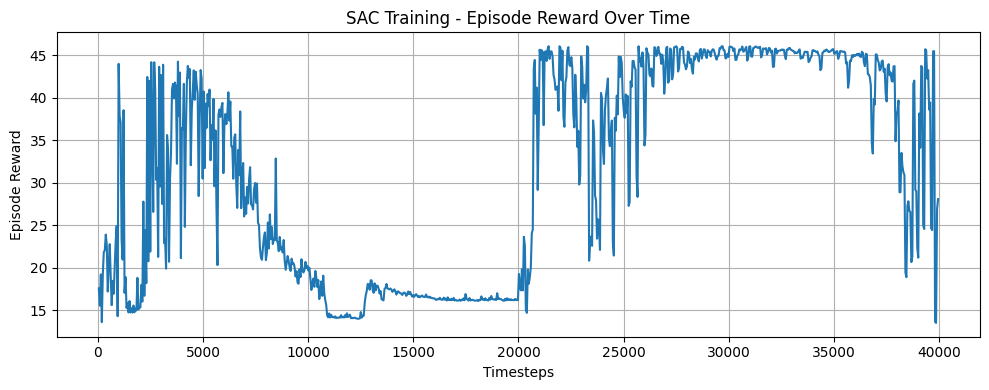

In [32]:
log_dir = "./logs/sac_max_norm_log"
x, y = ts2xy(load_results(log_dir), 'timesteps')

plt.figure(figsize=(10, 4))
plt.plot(x, y)
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.title("SAC Training - Episode Reward Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:

test_env= RetailerOrdersEnv2(time_horizon=47, track_data=True)
test_env_sc=  MinMaxWrapper2(test_env )

obs, *_ = test_env_sc.reset()


for step in range(47):
    action, _states = model.predict(obs, deterministic=True)  # Use deterministic actions
    obs, reward, done, truncated, info = test_env_sc.step(action)
    if done:
        break
import pandas as pd
pd.DataFrame(test_env_sc.env.history)


,demand,action,backlog,capacity,change_in_capacity,shipment_to_retailer,desired_shipment,cumulative_demand,cumulative_shipment,order_cost,supply_gap_cost,step_cost,reward,cumulative_cost
0,100.0,241.555466,1000.000000,100.000000,0.000000,100.000000,100.000000,0.0,0.000000,58.349045,0.000000,58.349045,-58.349045,0.000000
1,100.0,241.146515,1000.000000,100.000000,0.000000,100.000000,100.000000,100.0,100.000000,58.151642,0.000000,58.151642,-58.151642,58.349045
2,100.0,240.737656,1000.000000,100.000000,0.000000,100.000000,100.000000,200.0,200.000000,57.954620,0.000000,57.954620,-57.954620,116.500687
3,120.0,258.016541,1000.000000,100.000000,0.000000,100.000000,100.000000,300.0,300.000000,66.572540,0.000000,66.572540,-66.572540,174.455307
4,120.0,257.607483,1141.555466,100.000000,4.718516,100.000000,114.155547,420.0,400.000000,66.361618,0.800000,67.161621,-67.161621,241.027847
5,120.0,236.856750,1282.701981,104.718516,7.850561,104.718516,128.270198,540.0,500.000000,56.101124,3.200000,59.301125,-59.301125,308.189453
6,120.0,201.493347,1418.721121,112.569076,9.767679,112.569076,141.872112,660.0,604.718516,40.599571,6.112085,46.711656,-46.711656,367.490570
7,120.0,166.336075,1564.168585,122.336755,11.360035,122.336755,156.416858,780.0,717.287592,27.667690,7.865692,35.533383,-35.533383,414.202240
8,120.0,121.062996,1699.439313,133.696789,12.082381,133.696789,169.943931,900.0,839.624347,14.656250,7.290439,21.946689,-21.946689,449.735626
9,120.0,82.618576,1802.599274,145.779170,11.493586,145.779170,180.259927,1020.0,973.321136,6.825830,4.357833,11.183662,-11.183662,471.682312


In [34]:
actions=pd.DataFrame(test_env_sc.env.history)['action']
actions.to_csv('actions.csv', index=False)
reward=pd.DataFrame(test_env_sc.env.history).loc[35,'cumulative_cost']
print(f'reward: ',reward)

reward:  5314.2783203125


In [35]:
mean_reward, std_reward = evaluate_policy(model,test_env_sc, n_eval_episodes=1)  # Pass 'model' as a keyword argument
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")



Mean reward: 32.20 +/- 0.00


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [36]:
best_model = SAC.load("logs/best_model")
best_model.set_env(test_env_sc)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [37]:
mean_reward, std_reward = evaluate_policy(best_model,test_env_sc, n_eval_episodes=1)  # Pass 'model' as a keyword argument
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")



Mean reward: 46.05 +/- 0.00


In [38]:

test_env= RetailerOrdersEnv2(time_horizon=47, track_data=True)
test_env_sc=  MinMaxWrapper2(test_env )

obs, _ = test_env_sc.reset()

for step in range(47):
    action, _states = best_model.predict(obs, deterministic=True)  # Use deterministic actions
    obs, reward, done, truncated, info = test_env_sc.step(action)
    if done:
        break
import pandas as pd
pd.DataFrame(test_env_sc.env.history)

,demand,action,backlog,capacity,change_in_capacity,shipment_to_retailer,desired_shipment,cumulative_demand,cumulative_shipment,order_cost,supply_gap_cost,step_cost,reward,cumulative_cost
0,100.0,163.292908,1000.000000,100.000000,0.000000,100.000000,100.000000,0.0,0.000000,26.664576,0.000000,26.664576,-26.664576,0.000000
1,100.0,161.909515,1000.000000,100.000000,0.000000,100.000000,100.000000,100.0,100.000000,26.214693,0.000000,26.214693,-26.214693,26.664576
2,100.0,160.532257,1000.000000,100.000000,0.000000,100.000000,100.000000,200.0,200.000000,25.770607,0.000000,25.770607,-25.770607,52.879269
3,120.0,156.833298,1000.000000,100.000000,0.000000,100.000000,100.000000,300.0,300.000000,24.596685,0.000000,24.596685,-24.596685,78.649872
4,120.0,155.479340,1063.292908,100.000000,2.109764,100.000000,106.329291,420.0,400.000000,24.173826,0.800000,24.973825,-24.973825,103.246559
5,120.0,151.757385,1125.202423,102.109764,3.470160,102.109764,112.520242,540.0,500.000000,23.030306,3.200000,26.230307,-26.230307,128.220383
6,120.0,147.208282,1183.624917,105.579923,4.260856,105.579923,118.362492,660.0,602.109764,21.670280,6.702559,28.372839,-28.372839,154.450684
7,120.0,142.151245,1234.878291,109.840779,4.549017,109.840779,123.487829,780.0,707.689687,20.206978,10.457563,30.664541,-30.664541,182.823517
8,120.0,136.987335,1280.516851,114.389796,4.553963,114.389796,128.051685,900.0,817.530466,18.765530,13.602448,32.367978,-32.367978,213.488052
9,120.0,131.776062,1317.884441,118.943759,4.281562,118.943759,131.788444,1020.0,931.920262,17.364931,15.516080,32.881012,-32.881012,245.856033


In [39]:
actions=pd.DataFrame(test_env_sc.env.history)['action']
actions.to_csv('actions.csv', index=False)
reward=pd.DataFrame(test_env_sc.env.history).loc[35,'cumulative_cost']
print(f'reward: ',reward)

reward:  718.9823608398438
